In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",   # use Computer Modern for mathtext ($...$)
    "font.size": 13,
})


In [105]:
## Set up calibration
cal_date = "1001"
with open(f"cal_functions/{cal_date}.pkl", "rb") as f:
    cal = pickle.load(f)

cal_func = cal["function"]

In [ ]:
## choose data file
DIR = "/Users/charlottemyers/projects/jlab/spectro/data/"
files = ["Nate_Charlotte_1001_Run1.txt",
            "Nate_Charlotte_1001_Run2.txt",
            "Nate_Charlotte_1001_Run3.txt",
            "Nate_Charlotte_1001_Run4.txt",
            "Nate_Charlotte_1001_Run5.txt",
            "Nate_Charlotte_1001_Run6.txt",
            "Nate_Charlotte_1001_Run7.txt"]

run = 2
line = 3
path = DIR + files[run -1]

info = {
    "3": {"wl_range": (6560, 6566), "line_label": "Hα", "line": 6562.79},
    "4": {"wl_range": (4858, 4864), "line_label": "Hβ", "line": 4861.35},
    "5": {"wl_range": (4338, 4342), "line_label": "Hγ", "line": 4340.47}
}

['step', 'Monochromator-step', 'cps']
6420.0 6450.0


(6560.0, 6566.0)

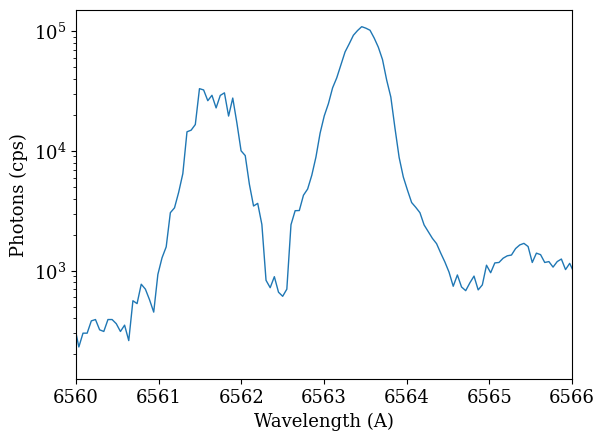

In [217]:
df = pd.read_csv(path, sep=r"\s+")
#df = df.iloc[:, [1, 2]].rename(columns={df.columns[0]: "step", df.columns[1]: "cps"})
print(df.columns.tolist())

step = df["Monochromator-step"].to_numpy()
wl = cal_func(step)
cps  = df["cps"].to_numpy()

plt.plot(wl, cps, lw=1, label = path.split("/")[-1])
plt.xlabel("Wavelength (A)")
plt.ylabel("Photons (cps)")
plt.yscale("log")

print(min(step), max(step))

# run = 3
# path = DIR + files[run -1]
# df = pd.read_csv(path, sep=r"\s+")
# step = df["Monochromator-step"].to_numpy()
# wl = cal_func(step)
# cps  = df["cps"].to_numpy()
# plt.plot(wl, cps, lw=1, label = path.split("/")[-1])

plt.xlim(info[str(line)]["wl_range"])
#plt.axvline(info[str(line)]["line"], color="k", ls="--", label=info[str(line)]["line_label"])
# plt.axvline(6562.9 )

In [218]:


def voigt(x, mu, sigma, gamma):
    # normalized Voigt profile
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

def two_voigts(x, A_H, mu_H, A_D, mu_D, sigma, gamma, C):
    return A_H*voigt(x, mu_H, sigma, gamma) + A_D*voigt(x, mu_D, sigma, gamma) + C

def two_gaussians(x, A_H, mu_H, A_D, mu_D, sigma, C):
    return A_H*np.exp(-(x - mu_H)**2 / (2*sigma**2)) + A_D*np.exp(-(x - mu_D)**2 / (2*sigma**2)) + C

Δλ = 1.79499 ± 0.01011 A
Δv = 81.99 ± 0.46 km/s
Gaussian fit: Δλ = 1.28858 ± 8553.21874 A
Gaussian fit: Δv = 58.86 ± 390717.30 km/s


Text(0, 0.5, 'Photons (cps)')

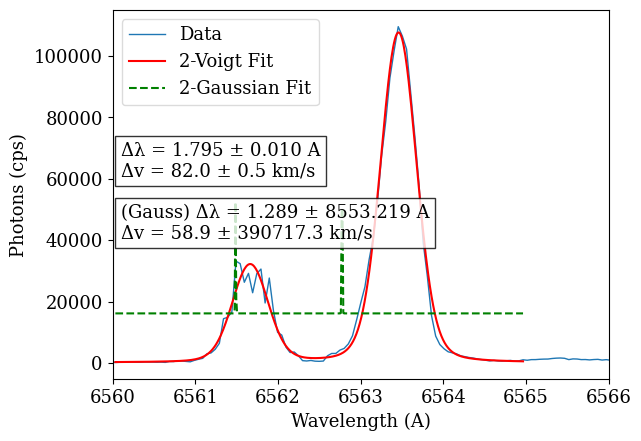

In [ ]:

mask = (wl > 6560) & (wl < 6565)
#mask = (wl > info[str(line)]["wl_range"][0]) & (wl < info[str(line)]["wl_range"][1])
xw = wl[mask]
yw = cps[mask]

# crude initial guesses
muH0 = info[str(line)]["line"]
muD0 = muH0 - 1.3
AH0  = yw.max()
AD0  = yw.max()/3
sigma0 = 0.05/2.355
gamma0 = 0.005
C0 = np.median(yw[:10])

p0 = [AH0, muH0, AD0, muD0, sigma0, gamma0, C0]
bounds = (
    [0, muH0-2, 0, muH0-5, 0, 0, -np.inf],  # lower
    [np.inf, muH0+2, np.inf, muH0+2, 2, 0.1, np.inf]  # upper (tune)
)


popt, pcov = curve_fit(two_voigts, xw, yw, p0=p0, bounds=bounds, maxfev=20000)
AH, muH, AD, muD, sigma, gamma, C = popt
perr = np.sqrt(np.diag(pcov))

dlam = muH - muD
# uncertainty via covariance (muH index 1, muD index 3)
var_dlam = pcov[1,1] + pcov[3,3] - 2*pcov[1,3]
sd_dlam = np.sqrt(max(var_dlam, 0.0))




# velocity splitting (use line center)
c_kms = 299792.458
vsplit = c_kms * dlam / muH
sv_vsplit = c_kms * sd_dlam / muH
print(f"Δλ = {dlam:.5f} ± {sd_dlam:.5f} A")
print(f"Δv = {vsplit:.2f} ± {sv_vsplit:.2f} km/s")

# plot fit
xf = np.linspace(xw.min(), xw.max(), 500)
yf = two_voigts(xf, *popt)
plt.plot(wl, cps, lw=1, label = "Data")
plt.plot(xf, yf, 'r-', label="2-Voigt Fit")

# annotate TEXT with true and expected splittings
text_x = info[str(line)]["wl_range"][0] + 0.1
text_y = yw.max()/1.8
plt.text(text_x, text_y, f"Δλ = {dlam:.3f} ± {sd_dlam:.3f} A\nΔv = {vsplit:.1f} ± {sv_vsplit:.1f} km/s",
         bbox=dict(facecolor='white', alpha=0.8))


######## GAUSSIAN FIT
p0g = [AH0, muH0, AD0, muD0, sigma0, C0]
boundsg = (
    [0, muH0-2, 0, muH0-5, 0, -np.inf],  # lower
    [np.inf, muH0+2, np.inf, muH0+2, 2, np.inf]
)
poptg, pcovg = curve_fit(two_gaussians, xw, yw, p0=p0g, bounds=boundsg, maxfev=20000)
AHg, muHg, ADg, muDg, sigmag, Cg = poptg
perrg = np.sqrt(np.diag(pcovg))
dlamg = muHg - muDg
var_dlamg = pcovg[1,1] + pcovg[3,3] - 2*pcovg[1,3]
sd_dlamg = np.sqrt(max(var_dlamg, 0.0))
vsplitg = c_kms * dlamg / muHg
sv_vsplitg = c_kms * sd_dlamg / muHg
print(f"Gaussian fit: Δλ = {dlamg:.5f} ± {sd_dlamg:.5f} A")
print(f"Gaussian fit: Δv = {vsplitg:.2f} ± {sv_vsplitg:.2f} km/s")
yfg = two_gaussians(xf, *poptg)
plt.plot(xf, yfg, 'g--', label="2-Gaussian Fit")
# annotation TEXT
plt.text(text_x, text_y/1.5, f"(Gauss) Δλ = {dlamg:.3f} ± {sd_dlamg:.3f} A\nΔv = {vsplitg:.1f} ± {sv_vsplitg:.1f} km/s",
         bbox=dict(facecolor='white', alpha=0.8))
#######



#####
plt.legend(framealpha = 0.7, loc = "upper left")
plt.xlim(info[str(line)]["wl_range"])
plt.xlabel("Wavelength (A)")
plt.ylabel("Photons (cps)")

Gaussian fit: Δλ = 1.79223 ± 0.00750 A
Gaussian fit: Δv = 81.86 ± 0.34 km/s


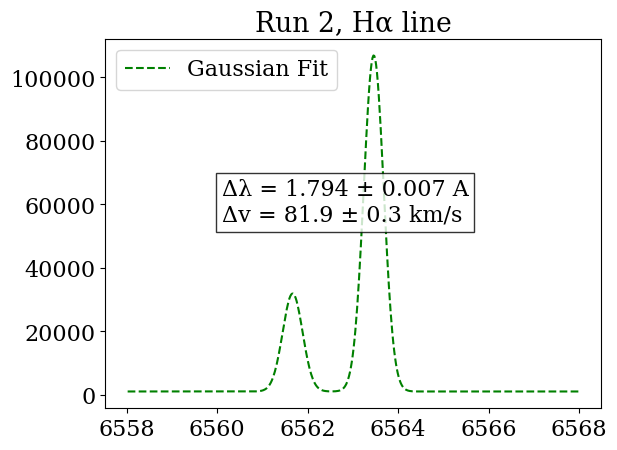

In [ ]:
# same process but for gaussian fit  (NEED TO DO FIT FIRST BEFORE PLOTTING)

p0g = [AH0, muH0, AD0, muD0, sigma0, C0]
boundsg = (
    [0, muH0-2, 0, muH0-5, 0, -np.inf],  # lower
    [np.inf, muH0+2, np.inf, muH0+2, 2, np.inf]
)
poptg, pcovg = curve_fit(two_gaussians, xw, yw, p0=p0g, bounds=boundsg, maxfev=20000)
AHg, muHg, ADg, muDg, sigmag, Cg = poptg
perrg = np.sqrt(np.diag(pcovg))
dlamg = muHg - muDg
var_dlamg = pcovg[1,1] + pcovg[3,3] - 2*pcovg[1,3]
sd_dlamg = np.sqrt(max(var_dlamg, 0.0))
vsplitg = c_kms * dlamg / muHg
sv_vsplitg = c_kms * sd_dlamg / muHg
print(f"Gaussian fit: Δλ = {dlamg:.5f} ± {sd_dlamg:.5f} A")
print(f"Gaussian fit: Δv = {vsplitg:.2f} ± {sv_vsplitg:.2f} km/s")
yfg = two_gaussians(xf, *poptg)
plt.plot(xf, yfg, 'g--', label="Gaussian Fit")
plt.legend()
plt.title(f"Run {run}, {info[str(line)]['line_label']} line")
plt.text(text_x, text_y, f"Δλ = {dlam:.3f} ± {sd_dlamg:.3f} A\nΔv = {vsplit:.1f} ± {sv_vsplit:.1f} km/s",
         bbox=dict(facecolor='white', alpha=0.8))
plt.show()
#plt.savefig(f"figs/Run{run}_line{line}_two_voigts.png", dpi=300)

peak location 1: 6563.445999811419
Fit parameters: [ 6.33810036e+04  6.56344600e+03  1.87210671e-01  5.45306256e-02
 -2.10945123e+02  6.00246331e+01]


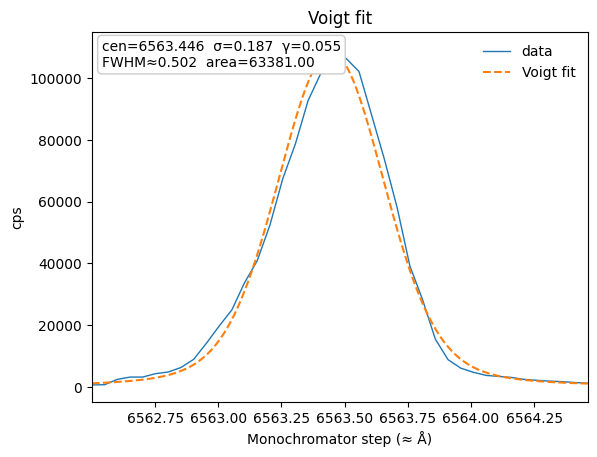

In [79]:


# Normalized Voigt (unit area).
def _voigt_norm(x, cen, sigma, gamma):
    z = ((x - cen) + 1j*gamma) / (sigma*np.sqrt(2))
    return np.real(wofz(z)) / (sigma*np.sqrt(2*np.pi))

# Model: area*Voigt + linear baseline
def voigt_model(x, area, cen, sigma, gamma, b0, b1):
    return area * _voigt_norm(x, cen, sigma, gamma) + (b0 + b1*(x - cen))

def fit_voigt_peak(step, cps, x0_rough, window=5.0, use_weights=True):
    # --- window data around the line ---
    m = (step >= x0_rough - window) & (step <= x0_rough + window)
    x, y = step[m].astype(float), cps[m].astype(float)

    # --- initial guesses ---
    cen0 = x[np.argmax(y)]
    ylo  = np.percentile(y, 10)
    yhi  = y.max()
    hm   = ylo + 0.5*(yhi - ylo)
    try:
        iL = np.where(y >= hm)[0][0]
        iR = np.where(y >= hm)[0][-1]
        fwhm0 = max( (x[iR] - x[iL]), 1e-3 )
    except Exception:
        fwhm0 = max(0.8, (x.max()-x.min())/6)  # fallback
    sigma0 = max(fwhm0/2.355, 1e-3)
    gamma0 = 0.5*sigma0
    area0  = max((yhi - ylo) * sigma0 * np.sqrt(2*np.pi), 1e-6)
    b0_0, b1_0 = float(ylo), 0.0

    p0 = [area0, cen0, sigma0, gamma0, b0_0, b1_0]
    bounds = (
        [0.0, cen0 - window, 1e-6, 1e-6, -np.inf, -np.inf],
        [np.inf, cen0 + window, window*2.0,  window*2.0,  np.inf,  np.inf],
    )

    sigma_y = None
    if use_weights:
        sigma_y = np.sqrt(np.clip(y, 1.0, None))  # Poisson-ish
    popt, pcov = curve_fit(
        voigt_model, x, y, p0=p0, bounds=bounds,
        sigma=sigma_y, absolute_sigma=True, maxfev=20000
    )
    area, cen, sigma, gamma, b0, b1 = popt

    # Approx Voigt FWHM (Olivero-Longbothum)
    fwhm = 0.5346*(2*gamma) + np.sqrt(0.2166*(2*gamma)**2 + (2.355*sigma)**2)

    # Plot
    xf = np.linspace(x.min(), x.max(), 1000)
    yf = voigt_model(xf, *popt)
    plt.plot(x, y, lw=1, label="data")
    plt.plot(xf, yf, ls="--", label="Voigt fit")

    # annotate
    txt = (f"cen={cen:.3f}  σ={sigma:.3f}  γ={gamma:.3f}\n"
           f"FWHM≈{fwhm:.3f}  area={area:.2f}")
    plt.text(0.02, 0.98, txt, transform=plt.gca().transAxes,
             ha="left", va="top", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.8"))
    plt.xlabel("Monochromator step (≈ Å)")
    plt.ylabel("cps")
    plt.legend(frameon=False)
    plt.title("Voigt fit")
    plt.xlim(x.min(), x.max())

    return popt, pcov, {"FWHM": fwhm}

# fit + plot
x0_rough = 6563.5
popt, pcov, extra = fit_voigt_peak(wl, cps, x0_rough, window=1.0, use_weights=True)
peak_location1 = popt[1]
print("peak location 1:", peak_location1)
print("Fit parameters:", popt)

Peak location: 6561.669796893593


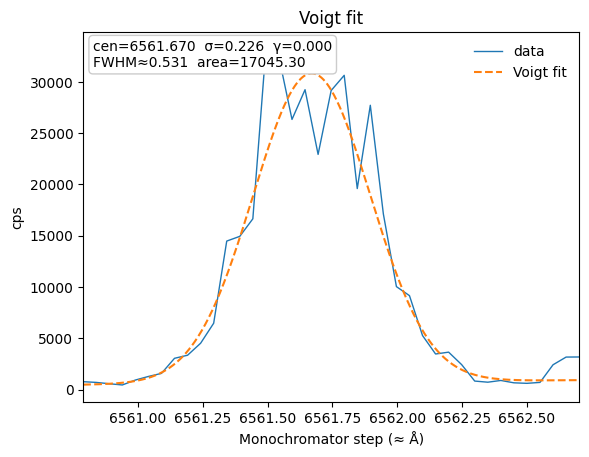

In [78]:
# fit voigt to 2 adjacent peaks, extract the max as the peak centers
x0_rough = 6561.75
popt1, pcov1, extra1 = fit_voigt_peak(wl, cps, x0_rough, window=1.0, use_weights=True)

peak_location2 = (popt1[1])
print("Peak location:", peak_location2)

In [80]:
delta_lambda = peak_location1 - peak_location2
print("Delta lambda (A):", delta_lambda)
print("Expected delta lambda (A):", 0.17846254*10)

Delta lambda (A): 1.7762029178256853
Expected delta lambda (A): 1.7846254
